In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import torch

# Add the path to the team_1 directory to sys.path
sys.path.insert(0,os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import from team_1
from team_1.utils import read_excel_sheet
from team_1.hospital_models.generic_torch_model import ClassificationVisualization
from team_1.task_24.task_24 import normalize_date_column, rename_columns_from_file, merge_dataframes_left_join, append_rehospitalized_status_to_patients
from team_1.task_24.patient_stas import process_rehospitalization_data
from team_1.task_37.pca_model import PCAClassificationPipeline

# Import from task_9 within the same module
from team_2.task_9.task_9 import EDA, rename_columns_from_json, read_csv_file
from team_2.task_20.task_20 import encode_and_correlate
from team_2.task_26.rehospital_model import train_nn_model, evaluate_model, prepare_data, encode_target
from team_2.task_38.task_38 import convert_date_to_numeric, encode_columns


In [2]:
os.getcwd()

'/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_2'

### **Adding Hospitalization1 Data**

(Assuming the data is fixed and without Hebrew Translation)

In [3]:
# Move two directories up
src_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Construct the full path to the file
#file_absolute_path = os.path.join(src_dir, "data/hospitalization1.csv")
#df = read_csv_file(file_absolute_path)

file_absolute_path_excel = os.path.join(src_dir, "data/rehospitalization.xlsx")

df = read_excel_sheet(file_absolute_path_excel, "hospitalization1")

### Translate Column names to english

In [4]:

translation_dir = os.path.join(src_dir, "team_1/translations")

df = rename_columns_from_json(df,translation_dir,"hospitalization1.json")

### **EDA hospitalization1 (Task 9)**

In [5]:
hospitilazation1 = EDA(df)

### Statistics and Histogram

In [6]:
hospitilazation1.stats()

First 5 indexes:
   Patient  department_id  Admission_Medical_Record    Admission_Entry_Date  \
0    62051              1                   5207766 2021-09-04 22:21:04.440   
1   951769              2                   5605505 2022-02-15 14:39:02.220   
2   863707              2                   6755794 2023-05-15 04:21:09.137   
3   884200              3                   6964052 2023-07-27 08:16:48.640   
4   936226              4                   7023187 2023-08-20 19:44:35.410   

         Release_Date reception_type patient_origin Release_Type  \
0 2021-09-08 14:43:00           דחוף          מביתו  שוחרר לביתו   
1 2022-02-16 13:37:00           דחוף            אחר  שוחרר לביתו   
2 2023-05-15 15:59:00           דחוף          מביתו  שוחרר לביתו   
3 2023-07-28 17:34:00           דחוף          ממוסד  שוחרר לביתו   
4 2023-08-21 15:47:00           דחוף          מביתו  שוחרר לביתו   

   release_doctor_code  hospitalization_duration admission_diagnoses  \
0               6878.0     

[[<Axes: title={'center': 'Patient'}>
  <Axes: title={'center': 'department_id'}>
  <Axes: title={'center': 'Admission_Medical_Record'}>]
 [<Axes: title={'center': 'Admission_Entry_Date'}>
  <Axes: title={'center': 'Release_Date'}>
  <Axes: title={'center': 'release_doctor_code'}>]
 [<Axes: title={'center': 'hospitalization_duration'}> <Axes: > <Axes: >]]
31075     53
354573    23
65151     14
3523      13
34605     13
          ..
590181     1
790490     1
6181       1
801748     1
431801     1
Name: Patient, Length: 4515, dtype: int64
1    1582
4    1582
3    1392
2    1263
5    1214
Name: department_id, dtype: int64
5207766    1
4638165    1
4684750    1
6659199    1
6194540    1
          ..
7240838    1
6422712    1
7232954    1
6810555    1
7229378    1
Name: Admission_Medical_Record, Length: 7033, dtype: int64
2021-09-04 22:21:04.440    1
2021-01-10 05:03:11.557    1
2021-01-29 21:15:59.523    1
2023-04-01 01:39:41.437    1
2022-09-24 02:36:33.567    1
                          

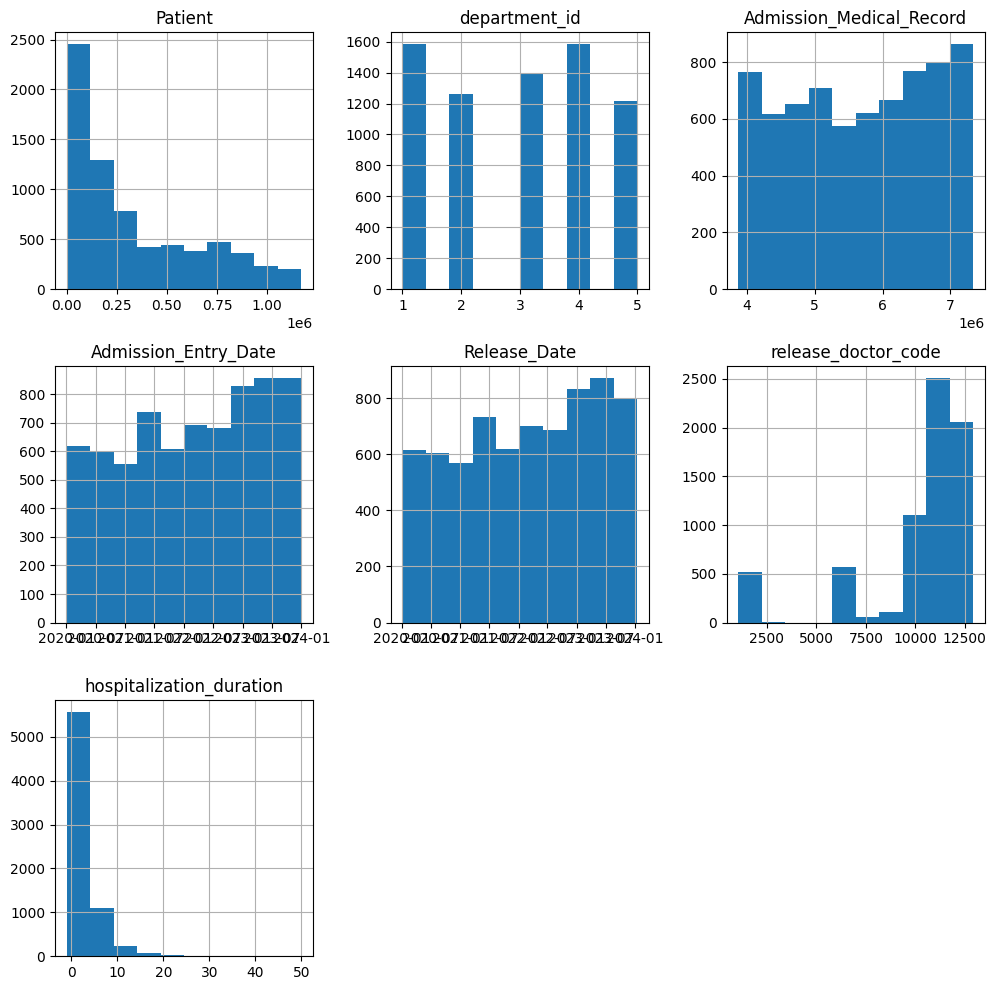

In [7]:
hospitilazation1.histogram()

**Conclusions from the Histogram**

Most hospitalizations were urgent and most were short, mainly a few days.

No drastic amount of patients in any specific unit.

/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_2/task_9/task_9.py:94: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(self.df.corr(), annot=True, cmap="coolwarm", fmt=".2f")


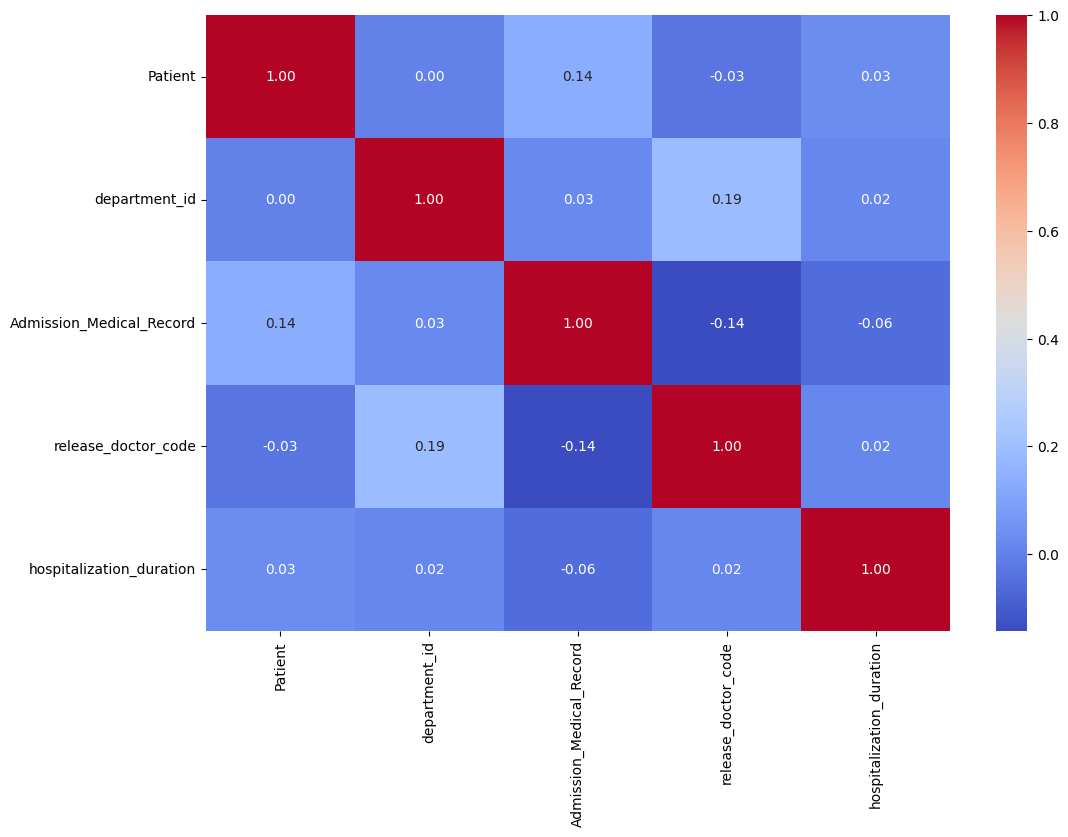

In [8]:
hospitilazation1.correlation()

**Conclusions from correlation Heatmap**

  No noticeable correlation between the different features.

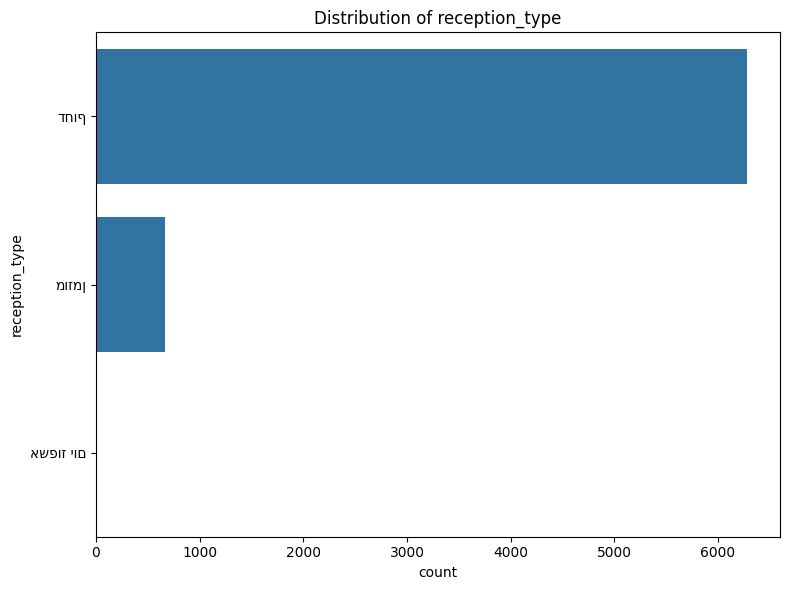

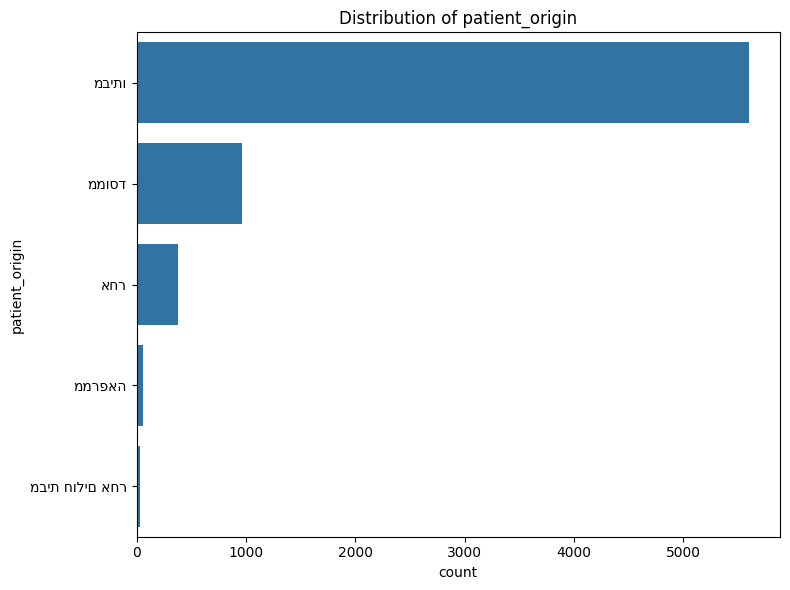

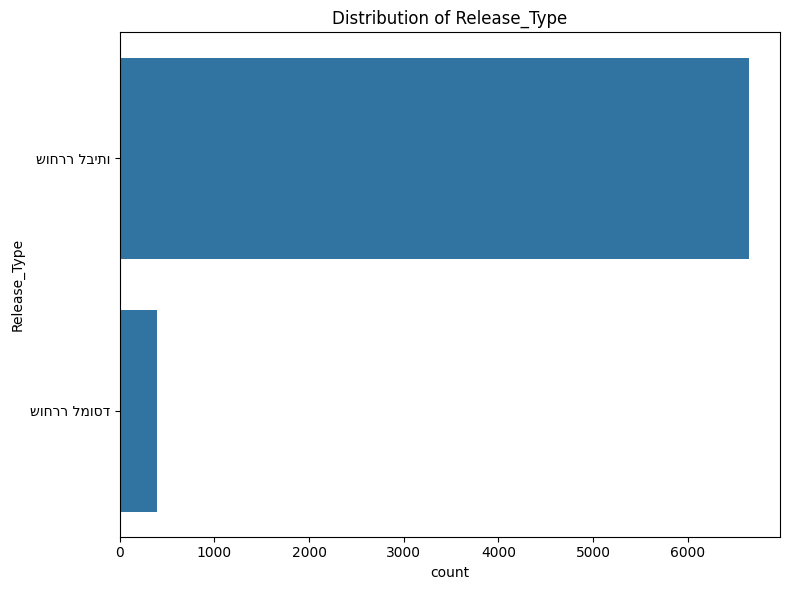

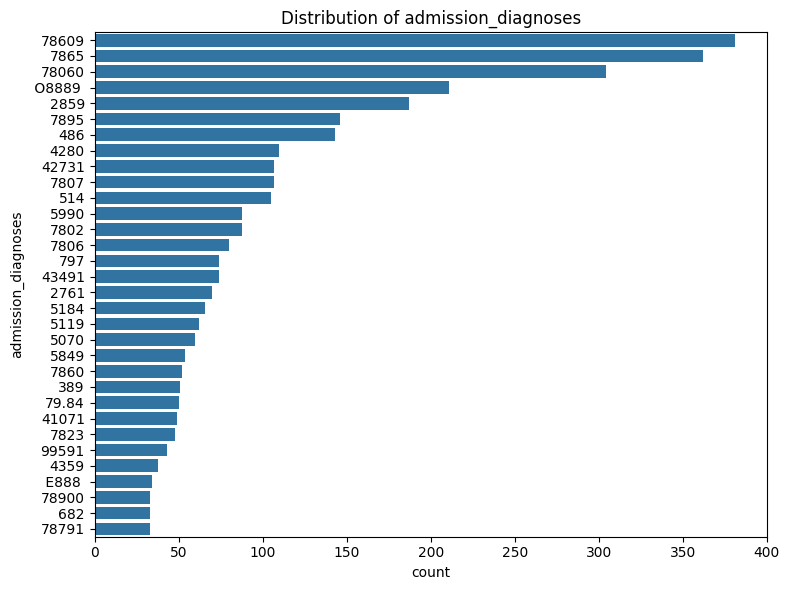

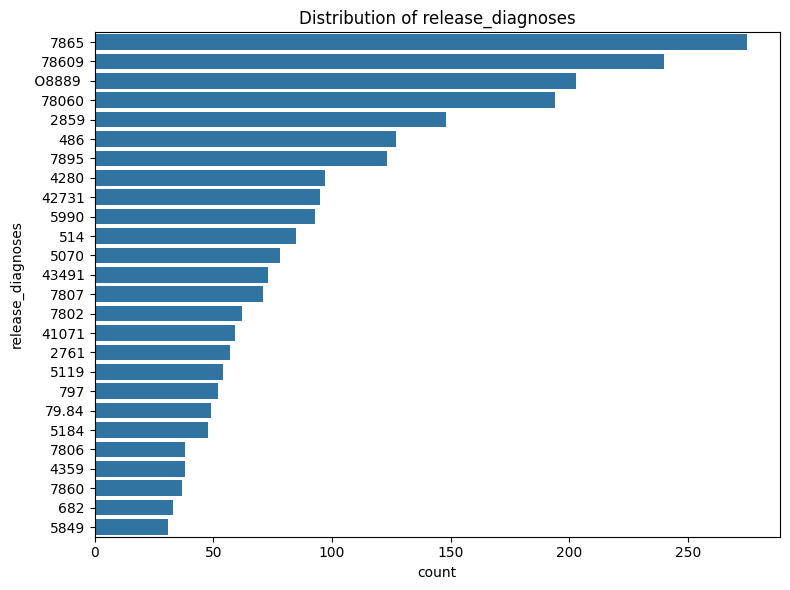

In [9]:
hospitilazation1.categorical_frequency(filter_columns=['admission_diagnoses', 'release_diagnoses'])

### Conclusions from Plots

Most hospitalization patients were excorted from home.

multiple diagnoses - top 10 dignoses:

Admission: 

1. 78609

2. 7865

3. 78060

4. 08889

5. 2859

6. 7895

7. 486

8. 4280

9. 42731

10. 7807
    
Release: all of the above and in addition 5990 & 514

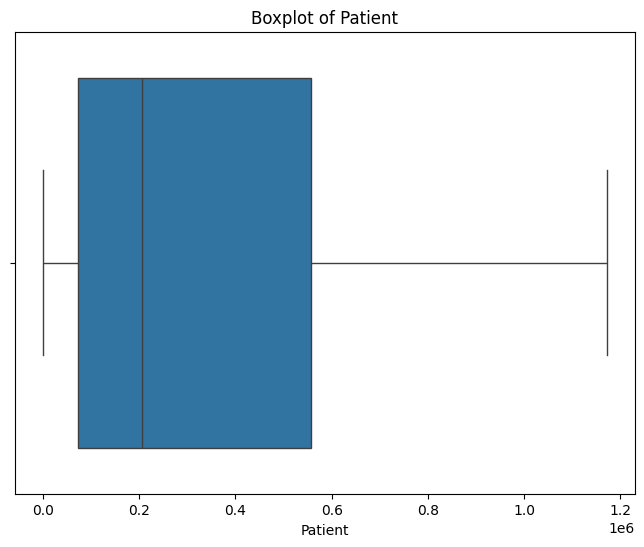

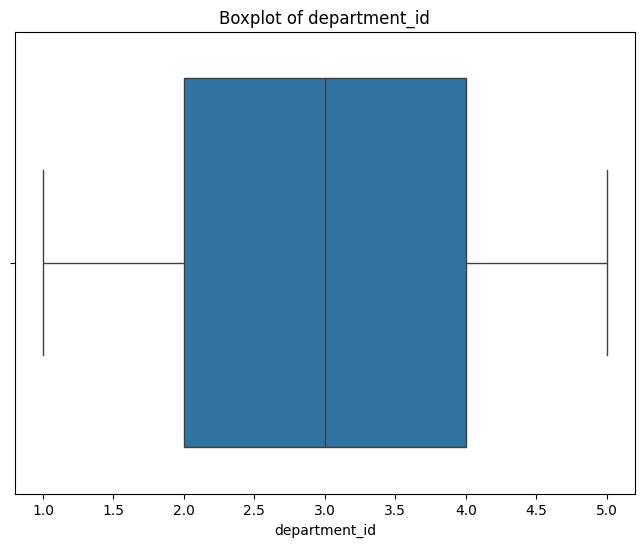

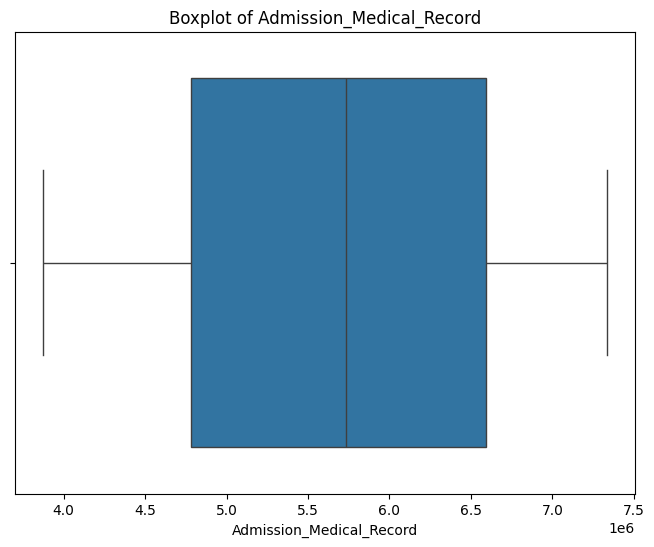

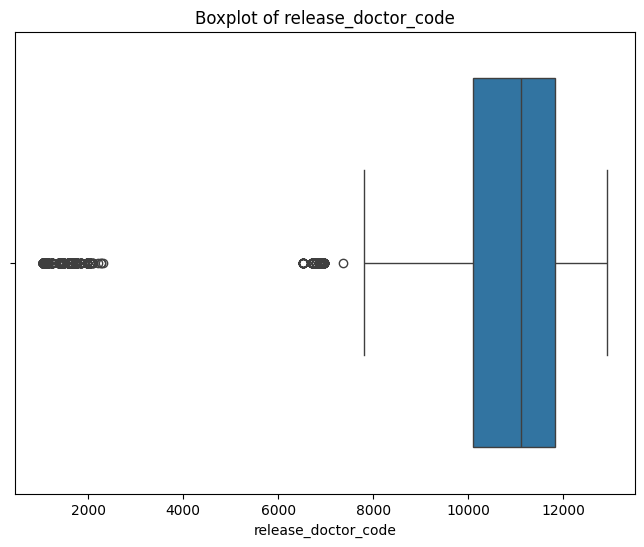

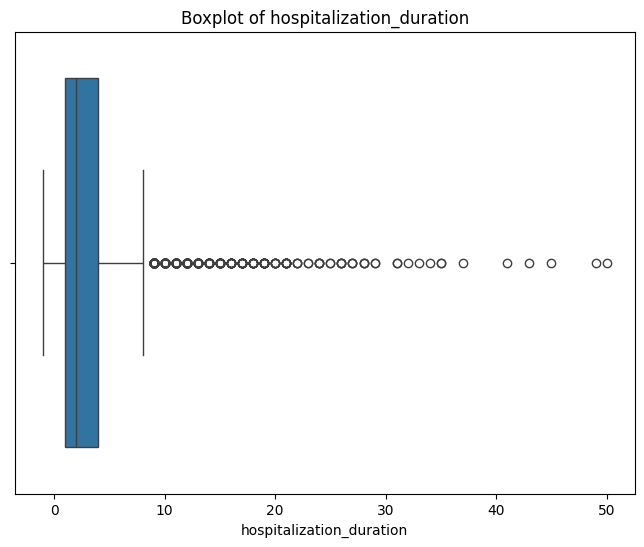

In [10]:
# Boxplots for numerical columns to identify outliers
hospitilazation1.outliers()

In [11]:
df[df.isnull().any(axis=1)]

,Patient,department_id,Admission_Medical_Record,Admission_Entry_Date,Release_Date,reception_type,patient_origin,Release_Type,release_doctor_code,hospitalization_duration,admission_diagnoses,release_diagnoses
22,209824,1,6221515,2022-10-08 09:29:34.083,2022-10-12 12:00:00,דחוף,מביתו,שוחרר לביתו,1147.0,4,NaN,79.84
44,348264,1,5343007,2021-11-03 07:52:41.453,2021-11-03 14:09:00,מוזמן,מביתו,שוחרר לביתו,11178.0,0,NaN,Other
55,58949,2,6984278,2023-08-03 21:44:06.410,2023-08-07 12:40:00,דחוף,אחר,שוחרר לביתו,11233.0,4,NaN,Other
79,586621,2,4347093,2020-08-24 11:05:42.410,2020-08-26 14:21:00,NaN,מביתו,שוחרר לביתו,10615.0,2,Other,Other
130,2435,1,4284638,2020-07-25 23:58:34.350,2020-07-31 00:12:00,דחוף,מביתו,שוחרר לביתו,NaN,6,Other,7895
...,...,...,...,...,...,...,...,...,...,...,...,...
6975,93771,2,6998293,2023-08-09 12:26:10.593,2023-08-10 13:45:00,דחוף,מביתו,שוחרר לביתו,11515.0,1,NaN,Other
6976,52684,5,6137087,2022-09-01 02:54:53.480,2022-09-08 13:03:00,דחוף,מביתו,שוחרר לביתו,NaN,7,486,Other
7016,926285,1,6106167,2022-08-15 21:49:11.407,2022-08-18 13:54:00,דחוף,מביתו,שוחרר לביתו,11206.0,3,NaN,Other
7022,303235,1,7319414,2023-12-26 09:25:25.690,2023-12-26 22:09:00,מוזמן,מביתו,שוחרר לביתו,1143.0,0,NaN,O8889


In [12]:
for col in df.columns:
    print(f"Unique values in '{col}':")
    print(df[col].value_counts())
    print("\n" + "="*40 + "\n")

Unique values in 'Patient':
31075     53
354573    23
65151     14
3523      13
34605     13
          ..
590181     1
790490     1
6181       1
801748     1
431801     1
Name: Patient, Length: 4515, dtype: int64


Unique values in 'department_id':
1    1582
4    1582
3    1392
2    1263
5    1214
Name: department_id, dtype: int64


Unique values in 'Admission_Medical_Record':
5207766    1
4638165    1
4684750    1
6659199    1
6194540    1
          ..
7240838    1
6422712    1
7232954    1
6810555    1
7229378    1
Name: Admission_Medical_Record, Length: 7033, dtype: int64


Unique values in 'Admission_Entry_Date':
2021-09-04 22:21:04.440    1
2021-01-10 05:03:11.557    1
2021-01-29 21:15:59.523    1
2023-04-01 01:39:41.437    1
2022-09-24 02:36:33.567    1
                          ..
2023-11-26 15:30:32.170    1
2022-12-29 22:00:43.417    1
2023-11-22 18:41:23.047    1
2023-06-05 14:00:02.710    1
2023-11-21 16:22:11.033    1
Name: Admission_Entry_Date, Length: 7033, dtype: int64



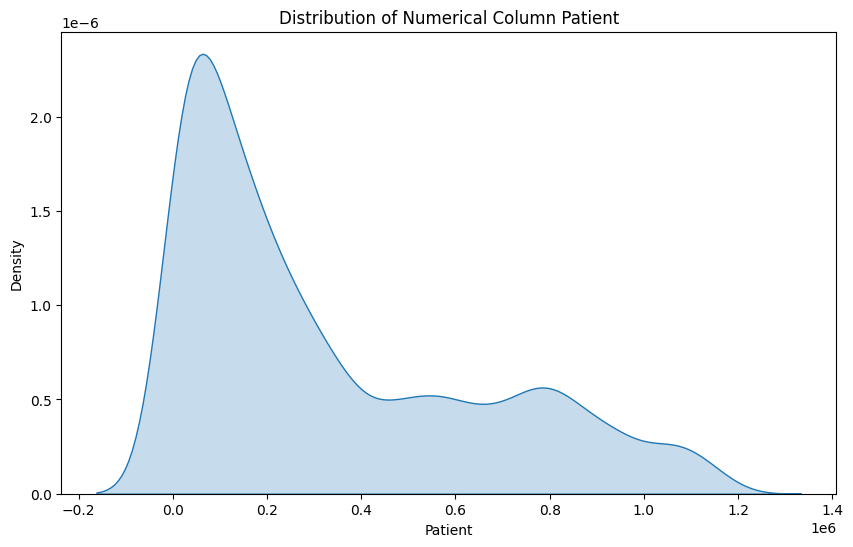

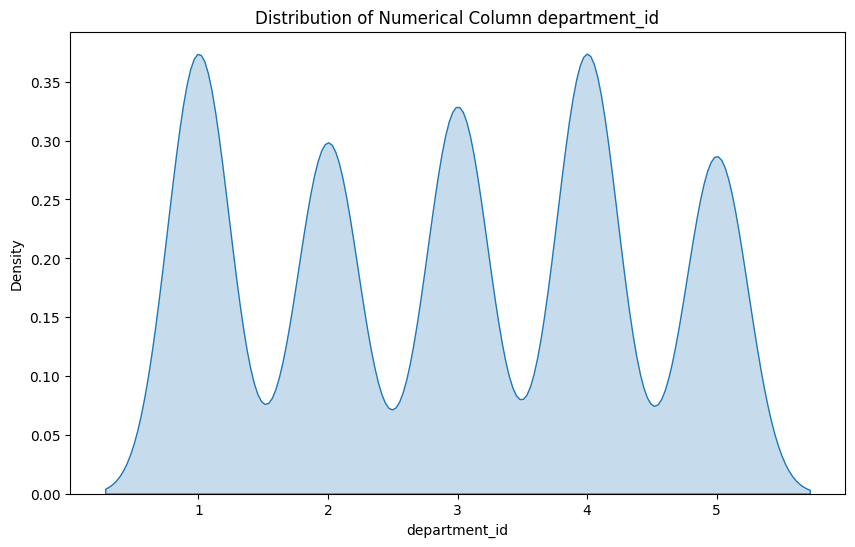

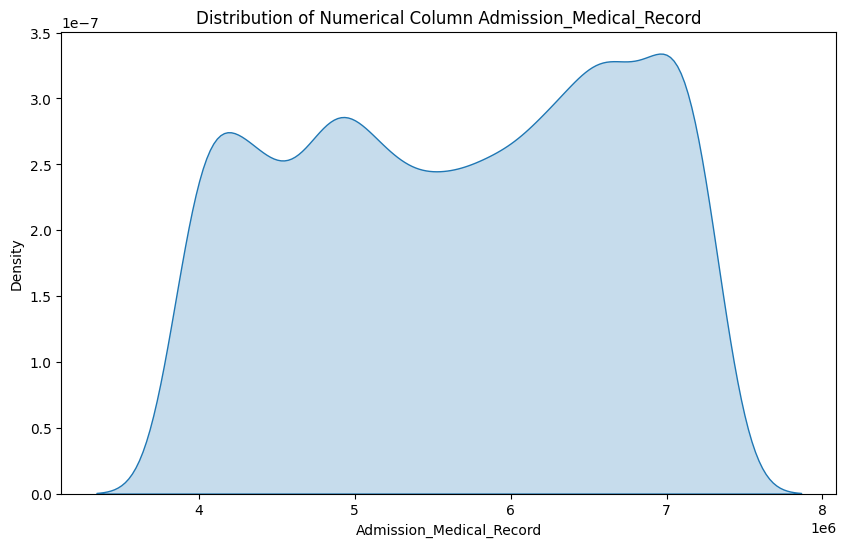

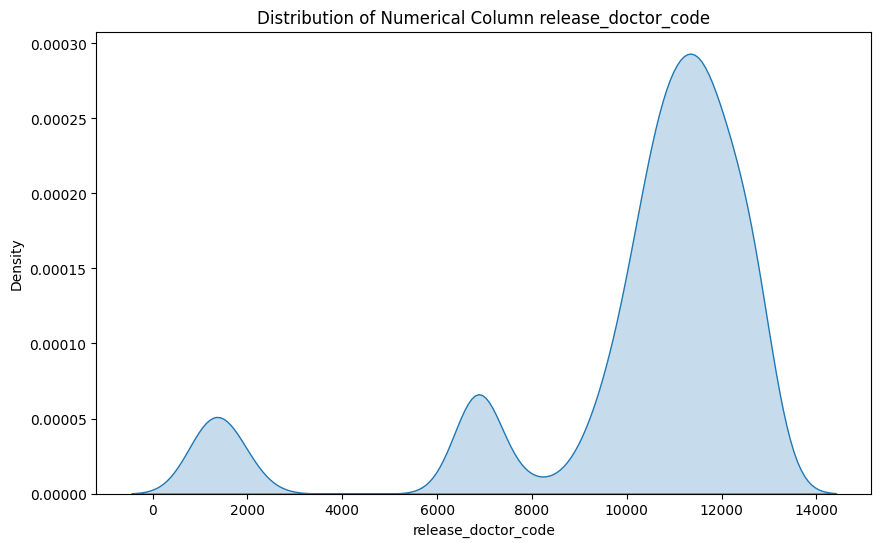

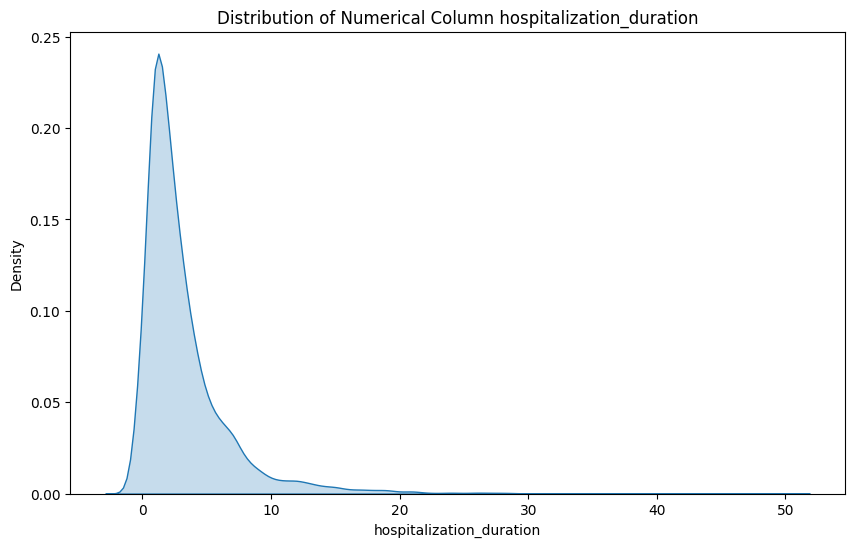

In [13]:
hospitilazation1.kde_numerical()

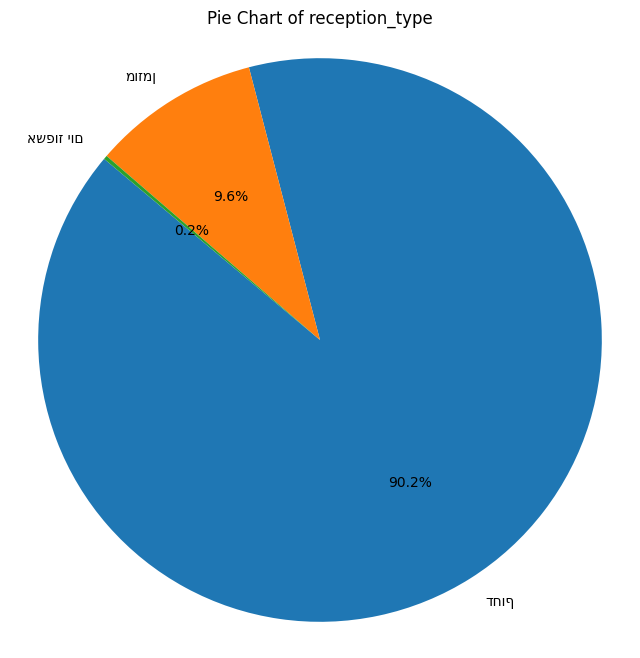

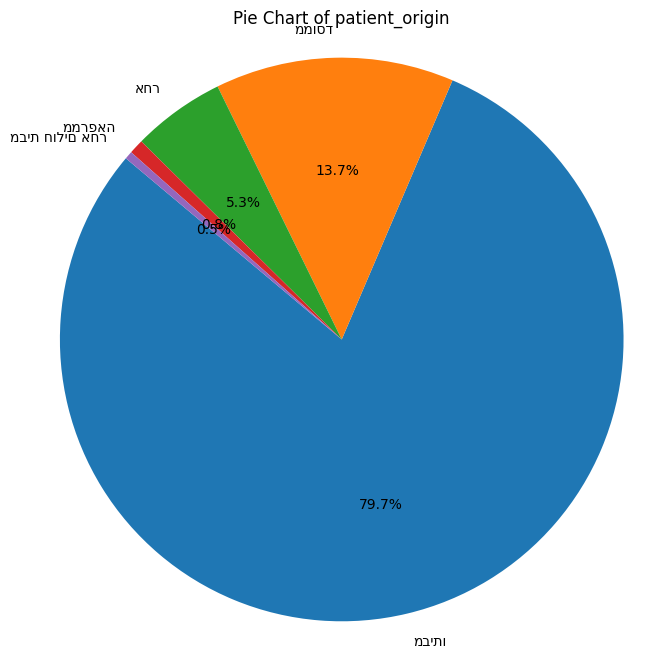

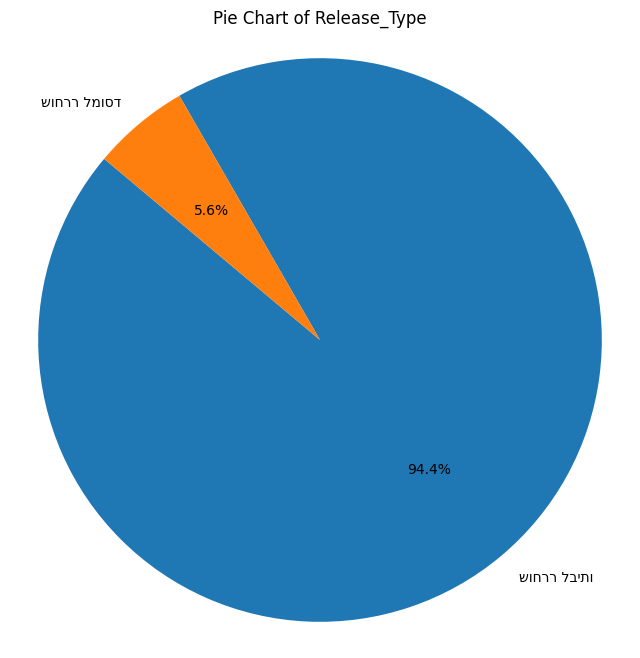

In [14]:
hospitilazation1.pie_charts_for_categorical()

### **Task 20**

In [15]:
# Construct the full path to the file
file_absolute_path_excel = os.path.join(src_dir, "data/rehospitalization.xlsx")

rDoctor_df = read_excel_sheet(file_absolute_path_excel, "רופאים משחררים מהאשפוז")
hDoctor_df = read_excel_sheet(file_absolute_path_excel, "hDoctor")

In [16]:
rDoctor_df = rename_columns_from_file(rDoctor_df, os.path.join(os.getcwd(), "translations", "release_Doctors_columns.json"))
hDoctor_df = rename_columns_from_file(hDoctor_df, os.path.join(os.getcwd(), "translations", "hDoctor_columns.json"))

In [17]:
hDoctor_df.head()

,date,release_doctor_code,patient_count
0,2020-01-01,7905,1
1,2020-01-01,8931,1
2,2020-01-01,7906,2
3,2020-01-01,11031,1
4,2020-01-01,9762,1


In [18]:
releaseDoctors = EDA(rDoctor_df)

In [19]:
releaseDoctors.stats()

First 5 indexes:
   release_doctor_code Senior
0                 1052      N
1                 1059      N
2                 1072      N
3                 1103      ?
4                 1107      N
Last 5 indexes:
     release_doctor_code Senior
209                12858      ?
210                12865      N
211                12886      N
212                12914      ?
213                12916      N
Column types:
release_doctor_code     int64
Senior                 object
dtype: object
Dataframe summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   release_doctor_code  214 non-null    int64 
 1   Senior               214 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.5+ KB
None
       release_doctor_code
count           214.000000
mean           9427.247664
std            3604.038767
min            1052.00000

[[<Axes: title={'center': 'release_doctor_code'}>]]
1052     1
11459    1
11482    1
11484    1
11504    1
        ..
9972     1
9975     1
9983     1
10014    1
12916    1
Name: release_doctor_code, Length: 214, dtype: int64
N                                     80
תלוי עד איזה תאריך מתייחסים ל-DATA    52
?                                     49
Y                                     33
Name: Senior, dtype: int64


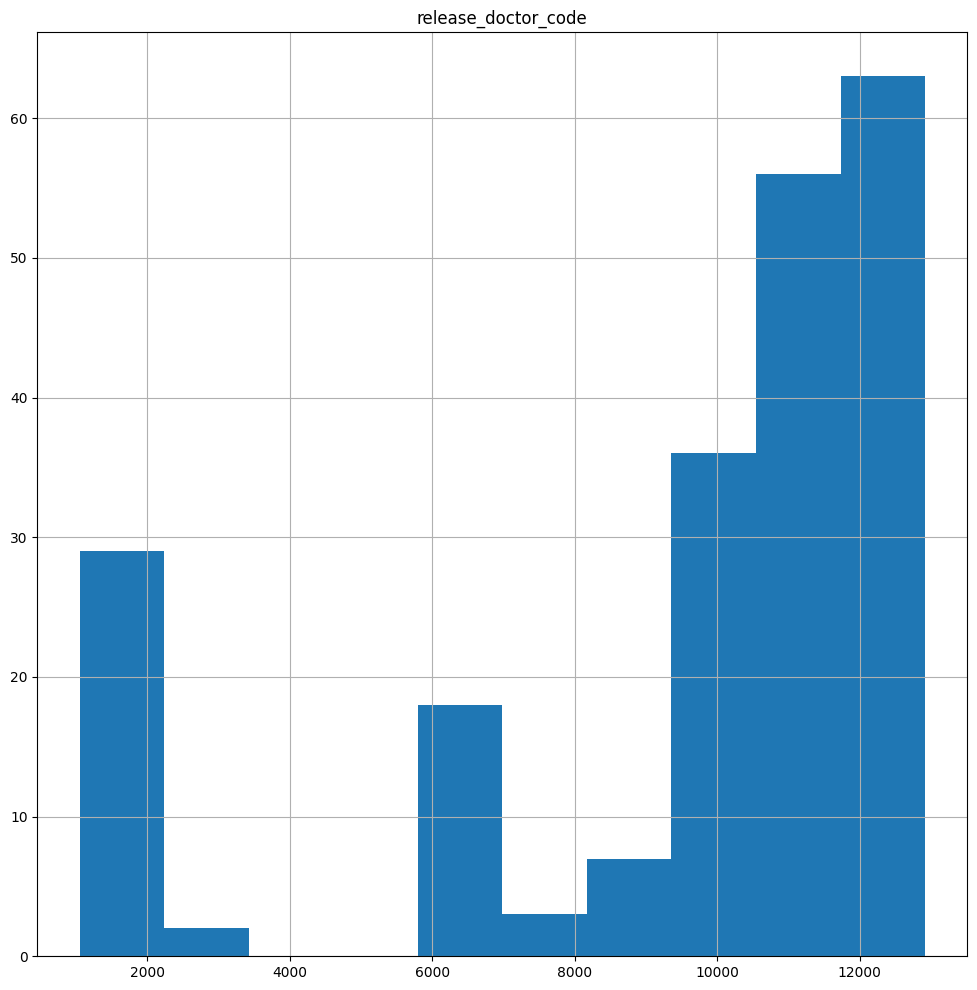

In [20]:
releaseDoctors.histogram()

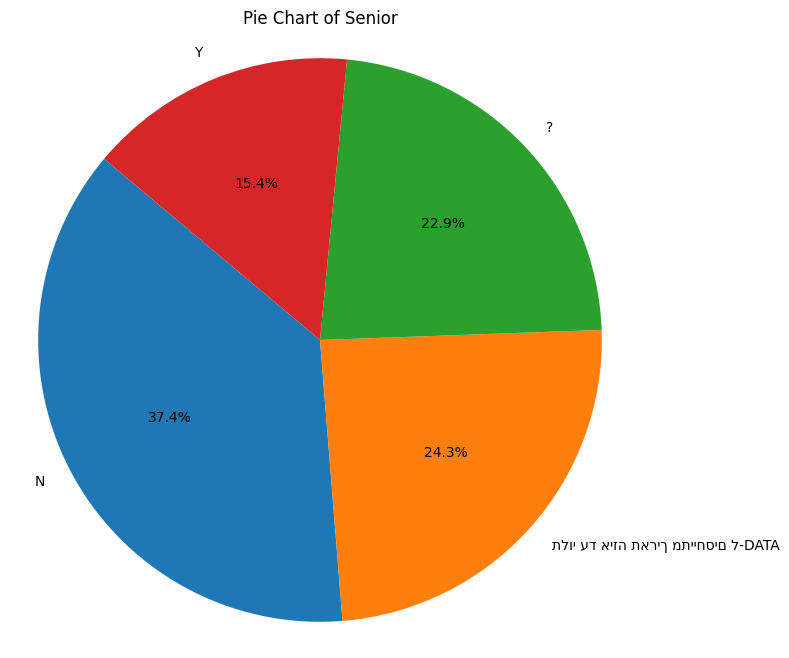

In [21]:
releaseDoctors.pie_charts_for_categorical()

- Based on Doctor rank data(Senior/Not Senior), the ranks are split almost equally to 4  categories: Yes, No, ? and Depends from which date.
- Based on the PIE chart, They're split almost equally in amount of doctors.

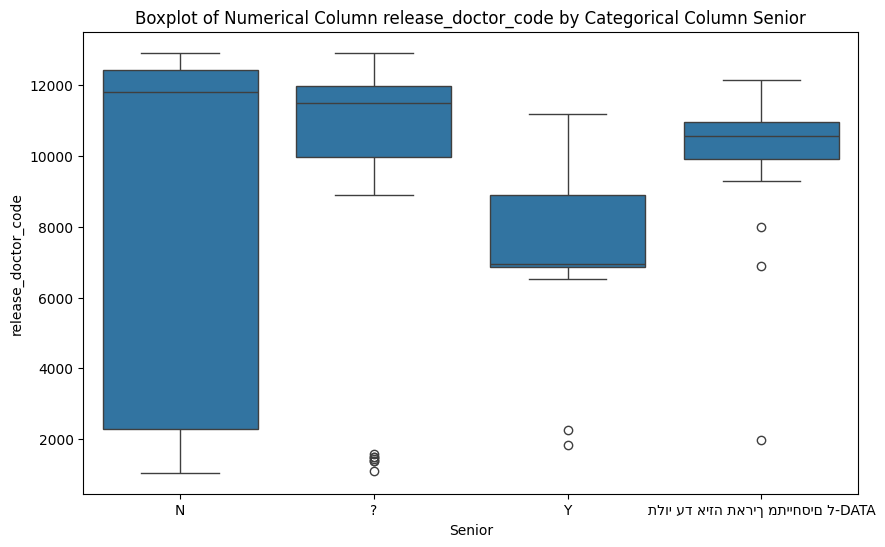

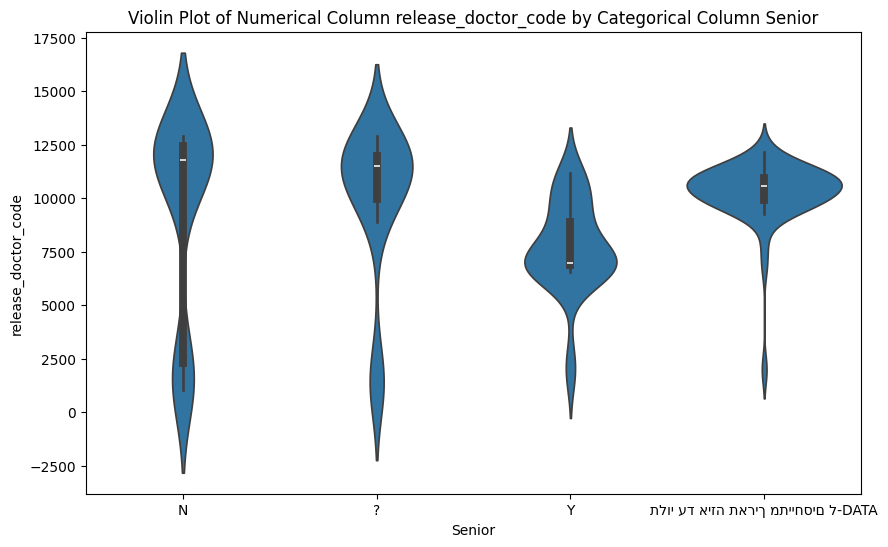

In [22]:
releaseDoctors.numeric_vs_categorical("release_doctor_code","Senior")

In [23]:
# remove null rows and normalize date in relevant dataframes
df = df.dropna()

for date_col in ['Admission_Entry_Date', 'Release_Date']:
    df[date_col] = normalize_date_column(df, column_name=date_col)

hDoctor_df['date'] = normalize_date_column(hDoctor_df, column_name='date')

/var/folders/b8/_2175njn05v2qj5673nczyfh0000gn/T/ipykernel_52366/4006769342.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_col] = normalize_date_column(df, column_name=date_col)
/var/folders/b8/_2175njn05v2qj5673nczyfh0000gn/T/ipykernel_52366/4006769342.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_col] = normalize_date_column(df, column_name=date_col)


In [24]:
df = append_rehospitalized_status_to_patients(df, column_name="Patient")
df.head()

/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_1/task_24/task_24.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rehospitalization_count"] = df.groupby(column_name)[column_name].transform(
/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_1/task_24/task_24.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_rehospitalization"] = df["rehospitalization_count"] > 1


,Patient,department_id,Admission_Medical_Record,Admission_Entry_Date,Release_Date,reception_type,patient_origin,Release_Type,release_doctor_code,hospitalization_duration,admission_diagnoses,release_diagnoses,rehospitalization_count,is_rehospitalization
0,62051,1,5207766,2021-09-04,2021-09-08,דחוף,מביתו,שוחרר לביתו,6878.0,4,42731,42731,3,True
1,951769,2,5605505,2022-02-15,2022-02-16,דחוף,אחר,שוחרר לביתו,12615.0,1,Other,Other,1,False
2,863707,2,6755794,2023-05-15,2023-05-15,דחוף,מביתו,שוחרר לביתו,12599.0,0,7895,7895,12,True
3,884200,3,6964052,2023-07-27,2023-07-28,דחוף,ממוסד,שוחרר לביתו,11582.0,1,78609,Other,1,False
4,936226,4,7023187,2023-08-20,2023-08-21,דחוף,מביתו,שוחרר לביתו,12359.0,1,78609,Other,1,False


In [25]:
# Filter the DataFrame to include only patients with at least 2 records
df_filtered = df[df['is_rehospitalization']]
df_filtered.head()

,Patient,department_id,Admission_Medical_Record,Admission_Entry_Date,Release_Date,reception_type,patient_origin,Release_Type,release_doctor_code,hospitalization_duration,admission_diagnoses,release_diagnoses,rehospitalization_count,is_rehospitalization
0,62051,1,5207766,2021-09-04,2021-09-08,דחוף,מביתו,שוחרר לביתו,6878.0,4,42731,42731,3,True
2,863707,2,6755794,2023-05-15,2023-05-15,דחוף,מביתו,שוחרר לביתו,12599.0,0,7895,7895,12,True
5,429566,3,6219263,2022-10-06,2022-10-08,דחוף,מביתו,שוחרר לביתו,11582.0,2,Other,Other,2,True
8,4767,5,6587317,2023-03-03,2023-03-05,דחוף,מביתו,שוחרר לביתו,11810.0,2,79.84,79.84,2,True
11,13171,5,6481821,2023-01-22,2023-01-24,דחוף,מביתו,שוחרר לביתו,9281.0,2,7802,Other,8,True


In [26]:
# Assuming 'doctor_id' is the common key
left_table_columns = ['release_doctor_code', 'Admission_Entry_Date']
right_table_columns = ['release_doctor_code', 'date']
df_combined1 = merge_dataframes_left_join(df_filtered, hDoctor_df, left_table_columns=left_table_columns, right_table_columns=right_table_columns)
df_combined1.head()

,Patient,department_id,Admission_Medical_Record,Admission_Entry_Date,Release_Date,reception_type,patient_origin,Release_Type,release_doctor_code,hospitalization_duration,admission_diagnoses,release_diagnoses,rehospitalization_count,is_rehospitalization,date,patient_count
0,62051,1,5207766,2021-09-04,2021-09-08,דחוף,מביתו,שוחרר לביתו,6878.0,4,42731,42731,3,True,2021-09-04,1.0
1,863707,2,6755794,2023-05-15,2023-05-15,דחוף,מביתו,שוחרר לביתו,12599.0,0,7895,7895,12,True,2023-05-15,1.0
2,429566,3,6219263,2022-10-06,2022-10-08,דחוף,מביתו,שוחרר לביתו,11582.0,2,Other,Other,2,True,2022-10-06,4.0
3,4767,5,6587317,2023-03-03,2023-03-05,דחוף,מביתו,שוחרר לביתו,11810.0,2,79.84,79.84,2,True,2023-03-03,1.0
4,13171,5,6481821,2023-01-22,2023-01-24,דחוף,מביתו,שוחרר לביתו,9281.0,2,7802,Other,8,True,2023-01-22,1.0


In [27]:
# Assuming 'doctor_id' is the common key
left_table_columns = ['release_doctor_code']
right_table_columns = ['release_doctor_code']
df_combined_full = merge_dataframes_left_join(df_combined1, rDoctor_df, left_table_columns, right_table_columns)
df_combined_full.head()

,Patient,department_id,Admission_Medical_Record,Admission_Entry_Date,Release_Date,reception_type,patient_origin,Release_Type,release_doctor_code,hospitalization_duration,admission_diagnoses,release_diagnoses,rehospitalization_count,is_rehospitalization,date,patient_count,Senior
0,62051,1,5207766,2021-09-04,2021-09-08,דחוף,מביתו,שוחרר לביתו,6878.0,4,42731,42731,3,True,2021-09-04,1.0,Y
1,863707,2,6755794,2023-05-15,2023-05-15,דחוף,מביתו,שוחרר לביתו,12599.0,0,7895,7895,12,True,2023-05-15,1.0,N
2,429566,3,6219263,2022-10-06,2022-10-08,דחוף,מביתו,שוחרר לביתו,11582.0,2,Other,Other,2,True,2022-10-06,4.0,N
3,4767,5,6587317,2023-03-03,2023-03-05,דחוף,מביתו,שוחרר לביתו,11810.0,2,79.84,79.84,2,True,2023-03-03,1.0,N
4,13171,5,6481821,2023-01-22,2023-01-24,דחוף,מביתו,שוחרר לביתו,9281.0,2,7802,Other,8,True,2023-01-22,1.0,תלוי עד איזה תאריך מתייחסים ל-DATA


In [28]:
# Calculate correlation for the entire dataset
global_correlation = encode_and_correlate(df_combined_full,['Senior'],['rehospitalization_count'],'label')
print(f"Global correlation between type of Dr. and rehospitalization: {global_correlation}")

Global correlation between type of Dr. and rehospitalization:         rehospitalization_count
Senior                -0.030248


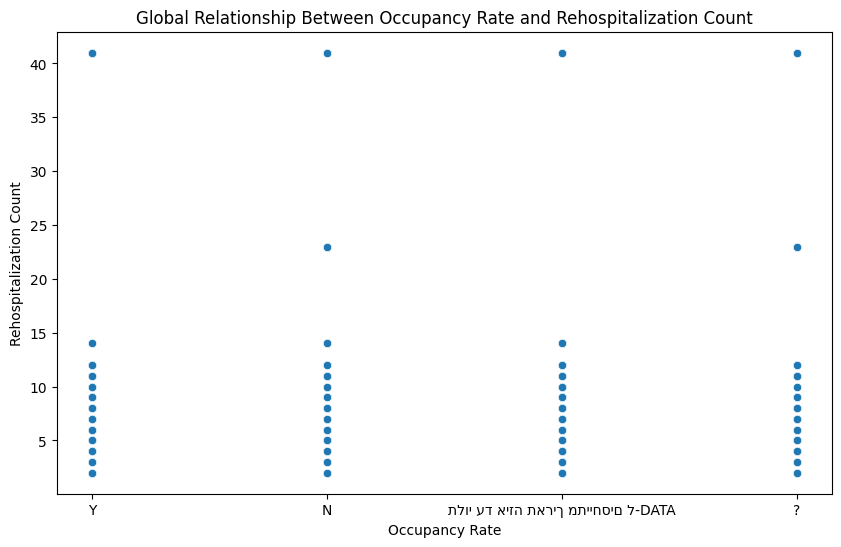

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Senior', y='rehospitalization_count', data=df_combined_full)
plt.title('Global Relationship Between Occupancy Rate and Rehospitalization Count')
plt.xlabel('Occupancy Rate')
plt.ylabel('Rehospitalization Count')
plt.show()

In [30]:
# Assuming 'doctor_id' is the common key
left_table_columns = ['release_doctor_code', 'Admission_Entry_Date']
right_table_columns = ['release_doctor_code', 'date']
df_classifier1 = merge_dataframes_left_join(df, hDoctor_df, left_table_columns=left_table_columns, right_table_columns=right_table_columns)

left_table_columns = ['release_doctor_code']
right_table_columns = ['release_doctor_code']
df_combined_classifier = merge_dataframes_left_join(df_classifier1, rDoctor_df, left_table_columns, right_table_columns)

_ = encode_and_correlate(df_combined_classifier,['Senior'],['rehospitalization_count'],'label')

# remove nan rows
df_combined_classifier = df_combined_classifier.dropna()

In [31]:
df_combined_classifier.head(5)

,Patient,department_id,Admission_Medical_Record,Admission_Entry_Date,Release_Date,reception_type,patient_origin,Release_Type,release_doctor_code,hospitalization_duration,admission_diagnoses,release_diagnoses,rehospitalization_count,is_rehospitalization,date,patient_count,Senior,Senior_encoded
0,62051,1,5207766,2021-09-04,2021-09-08,דחוף,מביתו,שוחרר לביתו,6878.0,4,42731,42731,3,True,2021-09-04,1.0,Y,2
1,951769,2,5605505,2022-02-15,2022-02-16,דחוף,אחר,שוחרר לביתו,12615.0,1,Other,Other,1,False,2022-02-15,1.0,N,1
2,863707,2,6755794,2023-05-15,2023-05-15,דחוף,מביתו,שוחרר לביתו,12599.0,0,7895,7895,12,True,2023-05-15,1.0,N,1
3,884200,3,6964052,2023-07-27,2023-07-28,דחוף,ממוסד,שוחרר לביתו,11582.0,1,78609,Other,1,False,2023-07-27,4.0,N,1
4,936226,4,7023187,2023-08-20,2023-08-21,דחוף,מביתו,שוחרר לביתו,12359.0,1,78609,Other,1,False,2023-08-20,1.0,N,1


In [32]:
features = ['release_doctor_code', 'Senior_encoded', 'hospitalization_duration']
X = df_combined_classifier[features]
y = df_combined_classifier['is_rehospitalization']

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest model
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5027522935779817
Classification Report:
               precision    recall  f1-score   support

       False       0.43      0.22      0.29       507
        True       0.52      0.75      0.62       583

    accuracy                           0.50      1090
   macro avg       0.48      0.48      0.45      1090
weighted avg       0.48      0.50      0.47      1090



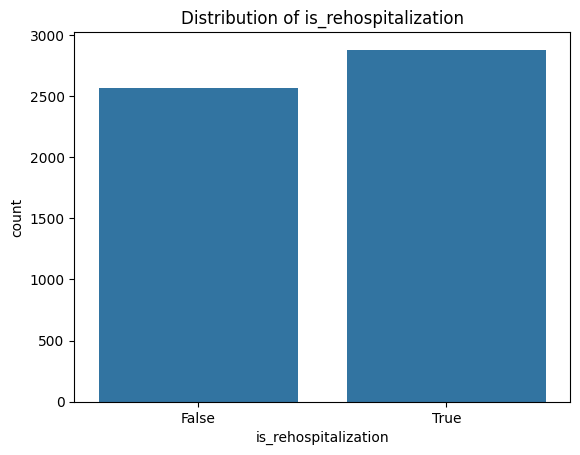

True     2882
False    2564
Name: is_rehospitalization, dtype: int64


In [35]:
sns.countplot(x=y)
plt.title('Distribution of is_rehospitalization')
plt.show()

# Alternatively
print(y.value_counts())

In [36]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
selector.fit(X_train)
constant_features = [column for column in X_train.columns if column not in X_train.columns[selector.get_support()]]
print(f"Constant or near-constant features: {constant_features}")

Constant or near-constant features: []


In [37]:
import numpy as np

corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.9
highly_correlated_features = [column for column in upper.columns if any(upper[column] > 0.9)]
print(f"Highly correlated features: {highly_correlated_features}")

Highly correlated features: []


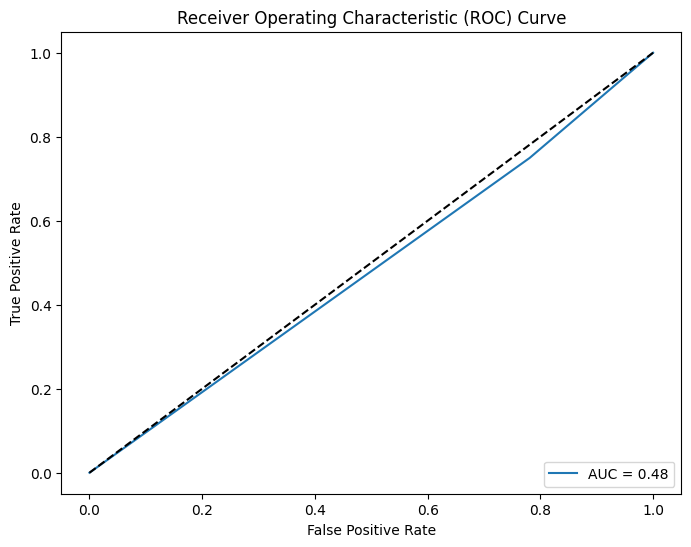

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

- Based on Gradient Boosting Model that predicts rehospitalization based on Doctor rank, the accuracy is 50% meaniing we need Feature Extraction/Engineering in the preprocessing.

## Task 26 Age & Gender to hospitalization model

In [39]:
general_data = read_excel_sheet(file_absolute_path_excel, "GeneralData")

In [40]:
translation_dir = os.path.join(src_dir, "team_1/translations")

general_data_df = rename_columns_from_json(general_data,translation_dir,"GeneralData.json")

In [41]:
general_data = EDA(general_data_df)
general_data_df.head()

,Patient,age,Gender,income_source,weight,height,BMI,illnesses,education,number_of_children,marital_status,medications
0,1043772,84,זכר,כללית,92.0,170.0,34.2,1,ללא,3,נשוי,"10815 , 11282 , 1183 , 1196 , 12758 , 13027 ,..."
1,77493,89,נקבה,‎ממון עצמי-לא מב‎,45.0,150.0,21.4,0,NaN,1,גרוש,"10337 , 1130 , 1448 , 1466 , 186 , 2482 , 290..."
2,37680,87,זכר,‎ממון עצמי-לא מב‎,67.7,165.0,24.9,0,פנסיונר,2,נשוי,"1183 , 1310 , 2451 , 2566 , 4967 , 6718 , 672..."
3,70066,90,נקבה,מאוחדת,94.0,165.0,31.6,0,NaN,1,גרוש,"1100 , 1181 , 1182 , 1183 , 12757 , 1283 , 12..."
4,13616,87,זכר,כללית,70.0,163.0,26.3,0,NaN,3,נשוי,"10214 , 1212 , 12725 , 2882 , 6737 , 7852 , 7..."


In [42]:
general_data_df.tail()

,Patient,age,Gender,income_source,weight,height,BMI,illnesses,education,number_of_children,marital_status,medications
4530,5473,82,זכר,‎ממון עצמי-לא מב‎,69.0,180.0,21.3,0,אלקטרונאי בפנסיה,3,נשוי,"1150 , 1682 , 2043 , 2150 , 2188 , 2566 , 260..."
4531,980451,79,זכר,מכבי,64.0,170.0,22.1,0,NaN,4,נשוי,NaN
4532,430555,99,זכר,כללית,60.0,170.0,20.8,0,פנסיונר,3,אלמן,"12284 , 2384 , 2412 , 2791 , 2843 , 3211 , 32..."
4533,737553,75,זכר,מכבי,97.0,170.0,33.6,0,תיווך,3,נשוי,"1183 , 12730 , 1637 , 2568 , 37 , 3724 , 4856..."
4534,769513,94,נקבה,מכבי,65.0,165.0,26.7,0,NaN,3,אלמן,"10201 , 1183 , 12722 , 1357 , 1443 , 1466 , 1..."


[[<Axes: title={'center': 'Patient'}> <Axes: title={'center': 'age'}>]
 [<Axes: title={'center': 'weight'}> <Axes: title={'center': 'height'}>]
 [<Axes: title={'center': 'BMI'}> <Axes: title={'center': 'illnesses'}>]]
1043772    1
20042      1
79811      1
59108      1
121623     1
          ..
270558     1
211853     1
56748      1
259403     1
769513     1
Name: Patient, Length: 4535, dtype: int64
85     205
74     191
76     181
83     177
80     172
82     172
75     165
88     160
89     159
87     157
78     152
71     152
70     152
79     152
73     152
72     148
77     147
86     146
84     145
81     142
68     134
90     133
69     130
91     125
66     115
67     114
65      93
92      91
93      88
94      63
95      60
97      48
96      42
98      27
99      24
100      9
101      4
103      2
102      2
105      2
104      1
111      1
Name: age, dtype: int64
זכר     2322
נקבה    2213
Name: Gender, dtype: int64
כללית                2439
‎ממון עצמי-לא מב‎     978
מכבי  

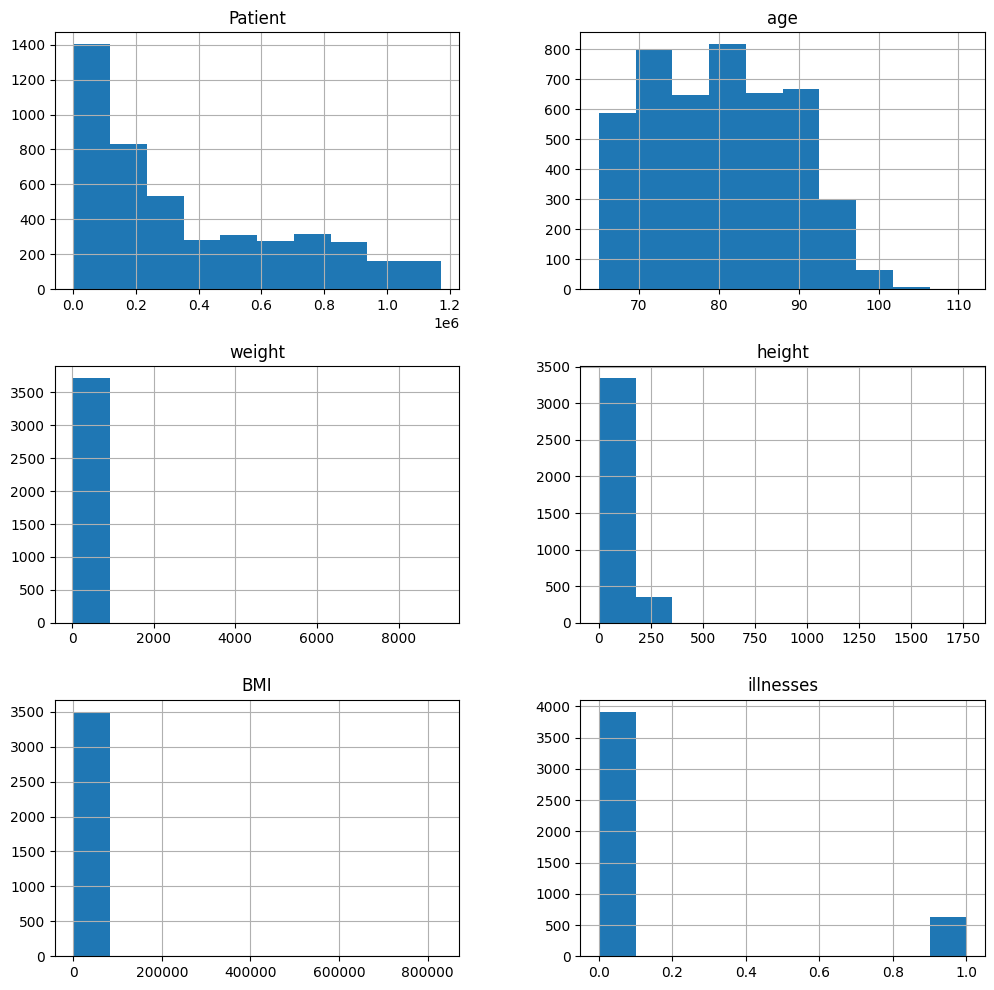

In [43]:
general_data.histogram()

In [44]:
for col in ['income_source', 'weight', 'height','BMI','education','number_of_children','marital_status','medications']:
    general_data.clean_nan(col)

Missing values in 'income_source' have been filled with כללית.
Missing values in 'weight' have been filled with 70.0.
Missing values in 'height' have been filled with 160.0.
Missing values in 'BMI' have been filled with 24.2.
Missing values in 'education' have been filled with פנסיונר.
Missing values in 'number_of_children' have been filled with 3.
Missing values in 'marital_status' have been filled with נשוי.
Missing values in 'medications' have been filled with 6720.


In [45]:
general_data_df.isna().sum()

Patient               0
age                   0
Gender                0
income_source         0
weight                0
height                0
BMI                   0
illnesses             0
education             0
number_of_children    0
marital_status        0
medications           0
dtype: int64

In [46]:
# Add duration classification
processed_df = process_rehospitalization_data(df=df, patient_col='Patient', admission_col='Admission_Entry_Date', release_col='Release_Date')
processed_df.head()

/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_1/task_24/patient_stas.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[admission_col] = pd.to_datetime(df[admission_col])
/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_1/task_24/patient_stas.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[release_col] = pd.to_datetime(df[release_col])
/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_1/task_24/patient_stas.py:20: SettingWithCop

,Patient,department_id,Admission_Medical_Record,Admission_Entry_Date,Release_Date,reception_type,patient_origin,Release_Type,release_doctor_code,hospitalization_duration,admission_diagnoses,release_diagnoses,rehospitalization_count,is_rehospitalization,hospitalization_count,previous_release,duration_between_hospitalizations,duration_classification
6842,31,4,4298122,2020-07-31,2020-07-31,דחוף,מביתו,שוחרר לביתו,10779.0,0,42731,42731,2,True,2,2020-07-27,4.0,short
1261,184,2,6245307,2022-10-21,2022-10-23,דחוף,מביתו,שוחרר לביתו,11515.0,2,7865,7865,2,True,2,2022-10-11,10.0,medium
6137,305,1,3905672,2020-01-16,2020-01-23,דחוף,מביתו,שוחרר לביתו,6892.0,7,Other,78609,4,True,4,2020-01-06,10.0,medium
6958,305,1,3951517,2020-02-04,2020-02-05,דחוף,מביתו,שוחרר לביתו,10762.0,1,78609,78609,4,True,4,2020-01-23,12.0,medium
928,305,1,3958841,2020-02-07,2020-02-11,דחוף,מביתו,שוחרר לביתו,7993.0,4,78609,78609,4,True,4,2020-02-05,2.0,short


In [47]:
# Assuming 'patient_id' is the common key
left_table_columns = ['Patient']
right_table_columns = ['Patient']
df_combined_26 = merge_dataframes_left_join(processed_df, general_data_df, left_table_columns=left_table_columns, right_table_columns=right_table_columns)
df_combined_26.head()

,Patient,department_id,Admission_Medical_Record,Admission_Entry_Date,Release_Date,reception_type,patient_origin,Release_Type,release_doctor_code,hospitalization_duration,...,Gender,income_source,weight,height,BMI,illnesses,education,number_of_children,marital_status,medications
0,31,4,4298122,2020-07-31,2020-07-31,דחוף,מביתו,שוחרר לביתו,10779.0,0,...,נקבה,מכבי,58.0,160.0,23.4,0,לא עובדת,1,אלמן,"11240 , 2188 , 2606 , 2690 , 2765 , 3633 , 38..."
1,184,2,6245307,2022-10-21,2022-10-23,דחוף,מביתו,שוחרר לביתו,11515.0,2,...,זכר,כללית,78.0,167.0,28.0,0,פנסיונר,1,נשוי,"1333 , 1530 , 2187 , 2188 , 2213 , 2214 , 260..."
2,305,1,3905672,2020-01-16,2020-01-23,דחוף,מביתו,שוחרר לביתו,6892.0,7,...,נקבה,כללית,70.0,165.0,26.7,0,פנסיונרית,1,אלמן,"1183 , 138 , 1530 , 1947 , 2044 , 2109 , 2188..."
3,305,1,3951517,2020-02-04,2020-02-05,דחוף,מביתו,שוחרר לביתו,10762.0,1,...,נקבה,כללית,70.0,165.0,26.7,0,פנסיונרית,1,אלמן,"1183 , 138 , 1530 , 1947 , 2044 , 2109 , 2188..."
4,305,1,3958841,2020-02-07,2020-02-11,דחוף,מביתו,שוחרר לביתו,7993.0,4,...,נקבה,כללית,70.0,165.0,26.7,0,פנסיונרית,1,אלמן,"1183 , 138 , 1530 , 1947 , 2044 , 2109 , 2188..."


In [48]:
df_combined_26.isna().sum()

Patient                              0
department_id                        0
Admission_Medical_Record             0
Admission_Entry_Date                 0
Release_Date                         0
reception_type                       0
patient_origin                       0
Release_Type                         0
release_doctor_code                  0
hospitalization_duration             0
admission_diagnoses                  0
release_diagnoses                    0
rehospitalization_count              0
is_rehospitalization                 0
hospitalization_count                0
previous_release                     0
duration_between_hospitalizations    0
duration_classification              0
age                                  0
Gender                               0
income_source                        0
weight                               0
height                               0
BMI                                  0
illnesses                            0
education                

In [49]:
# Step 1: Define the bins and bin the age column, save the bin ranges to a variable
age_bins = [0, 30, 60, 90, 120]
df_combined_26['age_binned'], bin_edges = pd.cut(df_combined_26['age'], bins=age_bins, labels=False, retbins=True)
df_combined_26.head()

,Patient,department_id,Admission_Medical_Record,Admission_Entry_Date,Release_Date,reception_type,patient_origin,Release_Type,release_doctor_code,hospitalization_duration,...,income_source,weight,height,BMI,illnesses,education,number_of_children,marital_status,medications,age_binned
0,31,4,4298122,2020-07-31,2020-07-31,דחוף,מביתו,שוחרר לביתו,10779.0,0,...,מכבי,58.0,160.0,23.4,0,לא עובדת,1,אלמן,"11240 , 2188 , 2606 , 2690 , 2765 , 3633 , 38...",2
1,184,2,6245307,2022-10-21,2022-10-23,דחוף,מביתו,שוחרר לביתו,11515.0,2,...,כללית,78.0,167.0,28.0,0,פנסיונר,1,נשוי,"1333 , 1530 , 2187 , 2188 , 2213 , 2214 , 260...",2
2,305,1,3905672,2020-01-16,2020-01-23,דחוף,מביתו,שוחרר לביתו,6892.0,7,...,כללית,70.0,165.0,26.7,0,פנסיונרית,1,אלמן,"1183 , 138 , 1530 , 1947 , 2044 , 2109 , 2188...",3
3,305,1,3951517,2020-02-04,2020-02-05,דחוף,מביתו,שוחרר לביתו,10762.0,1,...,כללית,70.0,165.0,26.7,0,פנסיונרית,1,אלמן,"1183 , 138 , 1530 , 1947 , 2044 , 2109 , 2188...",3
4,305,1,3958841,2020-02-07,2020-02-11,דחוף,מביתו,שוחרר לביתו,7993.0,4,...,כללית,70.0,165.0,26.7,0,פנסיונרית,1,אלמן,"1183 , 138 , 1530 , 1947 , 2044 , 2109 , 2188...",3


In [50]:
df_combined_26.columns

Index(['Patient', 'department_id', 'Admission_Medical_Record',
       'Admission_Entry_Date', 'Release_Date', 'reception_type',
       'patient_origin', 'Release_Type', 'release_doctor_code',
       'hospitalization_duration', 'admission_diagnoses', 'release_diagnoses',
       'rehospitalization_count', 'is_rehospitalization',
       'hospitalization_count', 'previous_release',
       'duration_between_hospitalizations', 'duration_classification', 'age',
       'Gender', 'income_source', 'weight', 'height', 'BMI', 'illnesses',
       'education', 'number_of_children', 'marital_status', 'medications',
       'age_binned'],
      dtype='object')

In [51]:

categorical_features = ['Gender', 'income_source', 'education']
numeric_features = ['age_binned', 'weight', 'height', 'BMI', 'hospitalization_duration', 'illnesses']

df_combined_26_encoded = encode_columns(df_combined_26, categorical_features)

df_combined_26_encoded.head()

,Patient,department_id,Admission_Medical_Record,Admission_Entry_Date,Release_Date,reception_type,patient_origin,Release_Type,release_doctor_code,hospitalization_duration,...,income_source,weight,height,BMI,illnesses,education,number_of_children,marital_status,medications,age_binned
0,31,4,4298122,2020-07-31,2020-07-31,דחוף,מביתו,שוחרר לביתו,10779.0,0,...,3,58.0,160.0,23.4,0,60,1,אלמן,"11240 , 2188 , 2606 , 2690 , 2765 , 3633 , 38...",2
1,184,2,6245307,2022-10-21,2022-10-23,דחוף,מביתו,שוחרר לביתו,11515.0,2,...,0,78.0,167.0,28.0,0,152,1,נשוי,"1333 , 1530 , 2187 , 2188 , 2213 , 2214 , 260...",2
2,305,1,3905672,2020-01-16,2020-01-23,דחוף,מביתו,שוחרר לביתו,6892.0,7,...,0,70.0,165.0,26.7,0,166,1,אלמן,"1183 , 138 , 1530 , 1947 , 2044 , 2109 , 2188...",3
3,305,1,3951517,2020-02-04,2020-02-05,דחוף,מביתו,שוחרר לביתו,10762.0,1,...,0,70.0,165.0,26.7,0,166,1,אלמן,"1183 , 138 , 1530 , 1947 , 2044 , 2109 , 2188...",3
4,305,1,3958841,2020-02-07,2020-02-11,דחוף,מביתו,שוחרר לביתו,7993.0,4,...,0,70.0,165.0,26.7,0,166,1,אלמן,"1183 , 138 , 1530 , 1947 , 2044 , 2109 , 2188...",3


In [52]:
# Prepare the data
X_train, X_test, y_train, y_test = prepare_data(df_combined_26_encoded, categorical_features, numeric_features, 'duration_classification')

# Define model parameters
input_size = X_train.shape[1]
hidden_size = 64  # Example size
num_classes = len(df_combined_26['duration_classification'].unique())  # Number of output classes

In [53]:
# Train the model
model, losses = train_nn_model(X_train, y_train, input_size, hidden_size, num_classes, num_epochs=100, learning_rate=0.01, dropout_prob=0.5, print_every=10)

Epoch [10/100], Loss: 1.0891
Epoch [20/100], Loss: 1.0883
Epoch [30/100], Loss: 1.0845
Epoch [40/100], Loss: 1.0860
Epoch [50/100], Loss: 1.0805
Epoch [60/100], Loss: 1.0832
Epoch [70/100], Loss: 1.0787
Epoch [80/100], Loss: 1.0778
Epoch [90/100], Loss: 1.0782
Epoch [100/100], Loss: 1.0736


In [54]:

# Evaluate the model
evaluate_model(model, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       150
           1       0.26      0.28      0.27       128
           2       0.44      0.29      0.35       164

    accuracy                           0.34       442
   macro avg       0.35      0.34      0.33       442
weighted avg       0.35      0.34      0.34       442

Accuracy: 0.3394


In [55]:
# Create the visualization object
vis = ClassificationVisualization()

In [56]:
with torch.no_grad():
    outputs = model.forward(X_test)
    _, y_pred = torch.max(outputs.data, 1)

/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_1/hospital_models/generic_torch_model.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_true, palette="viridis")
/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_1/hospital_models/generic_torch_model.py:218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="viridis")


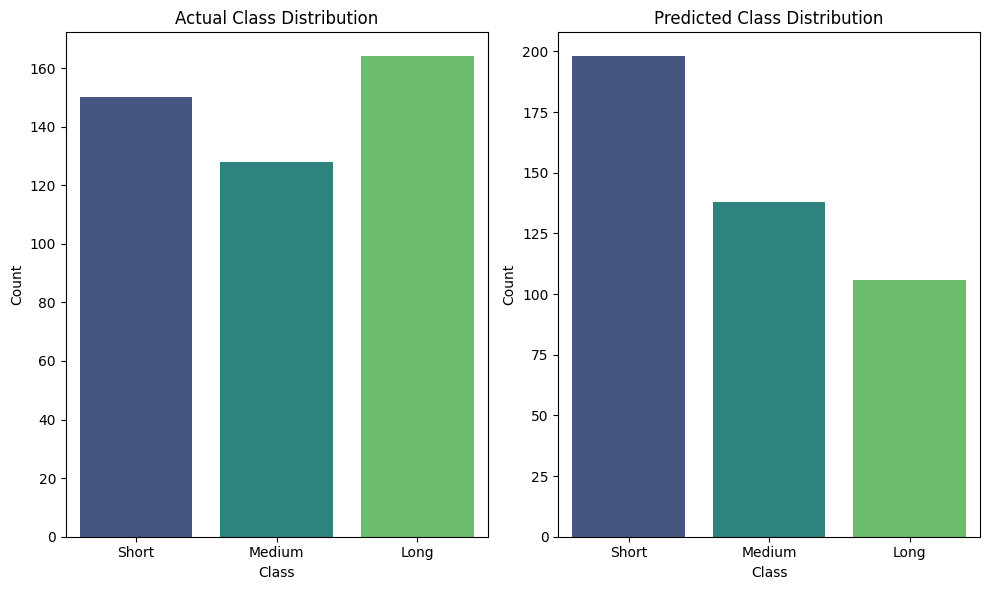

In [57]:
class_names = ["Short", "Medium", "Long"]

# Plot countplot for actual vs predicted class distribution
vis.plot_countplot(y_test, y_pred, class_names)

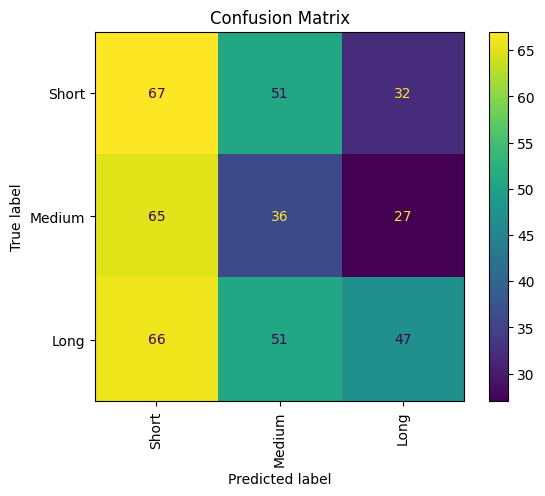

In [58]:
# Plot countplot for actual vs predicted class distribution
vis.plot_confusion_matrix(y_test, y_pred, class_names)

## **Task 38**

### Insert Cleaned Hospitalization 2

In [59]:
# Move two directories up
src_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Construct the full path to the file
file_absolute_path = os.path.join(src_dir, "data/hospitalization2_Team_10.csv")
df_2 = read_csv_file(file_absolute_path)

In [60]:
hospitalization2 = EDA(df_2)
df_2.head()

,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,Entry_Type,Patient_Origin,Release_Type,Releasing_Doctor,Admission_Days2,Diagnosis_In_Reception,Diagnosis_In_Release,ct
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,5,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,urgent,home,home,11023,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",0
1,447962,4,6084166,2022-08-07 13:27:58.780,2022-08-08 15:15:00,4,6137129,2022-09-01 04:20:51.617,2022-09-02 16:00:00,urgent,home,home,12517,1,78060,78060,0
2,214558,5,7164813,2023-10-27 07:34:41.013,2023-10-29 17:18:00,5,7172678,2023-10-30 17:58:09.730,2023-11-01 15:33:00,urgent,home,home,11887,2,5119,"5119 , 514",0
3,71277,3,4295329,2020-07-29 17:00:56.863,2020-08-03 14:26:00,3,4354333,2020-08-30 04:25:30.670,2020-09-03 13:45:00,urgent,home,home,10525,4,"2859 , 7807","486 , 5990",0
4,112016,1,5052676,2021-07-03 11:42:24.973,2021-07-05 17:34:00,1,5078317,2021-07-13 01:21:32.077,2021-07-15 11:48:00,urgent,home,home,6890,2,7865,7865,1


In [61]:
hospitalization2.stats()

First 5 indexes:
   Patient  unitName1  Admission_Medical_Record     Admission_Entry_Date  \
0   430047          5                   4727327  2021-02-16 17:33:45.570   
1   447962          4                   6084166  2022-08-07 13:27:58.780   
2   214558          5                   7164813  2023-10-27 07:34:41.013   
3    71277          3                   4295329  2020-07-29 17:00:56.863   
4   112016          1                   5052676  2021-07-03 11:42:24.973   

          Release_Date  unitName2  Admission_Medical_Record2  \
0  2021-02-19 12:40:00          5                    4745943   
1  2022-08-08 15:15:00          4                    6137129   
2  2023-10-29 17:18:00          5                    7172678   
3  2020-08-03 14:26:00          3                    4354333   
4  2021-07-05 17:34:00          1                    5078317   

     Admission_Entry_Date2        Release_Date2 Entry_Type Patient_Origin  \
0  2021-02-24 15:03:30.490  2021-02-25 12:38:00     urgent      

[[<Axes: title={'center': 'Patient'}>
  <Axes: title={'center': 'unitName1'}>
  <Axes: title={'center': 'Admission_Medical_Record'}>]
 [<Axes: title={'center': 'unitName2'}>
  <Axes: title={'center': 'Admission_Medical_Record2'}>
  <Axes: title={'center': 'Releasing_Doctor'}>]
 [<Axes: title={'center': 'Admission_Days2'}>
  <Axes: title={'center': 'ct'}> <Axes: >]]
31075      146
377264      38
8873        29
354573      28
749573      27
          ... 
216961       1
1127902      1
168978       1
929134       1
205787       1
Name: Patient, Length: 4513, dtype: int64
1    2026
4    1985
3    1758
2    1595
5    1551
Name: unitName1, dtype: int64
6224664    6
4895198    6
6237728    6
4911032    6
6427795    5
          ..
5599544    1
4710720    1
4444914    1
5066670    1
5234530    1
Name: Admission_Medical_Record, Length: 7031, dtype: int64
2022-10-11 05:21:19.177    6
2021-05-01 06:20:12.390    6
2022-10-19 00:30:20.500    6
2021-05-06 13:07:11.350    6
2023-01-01 19:34:37.463    

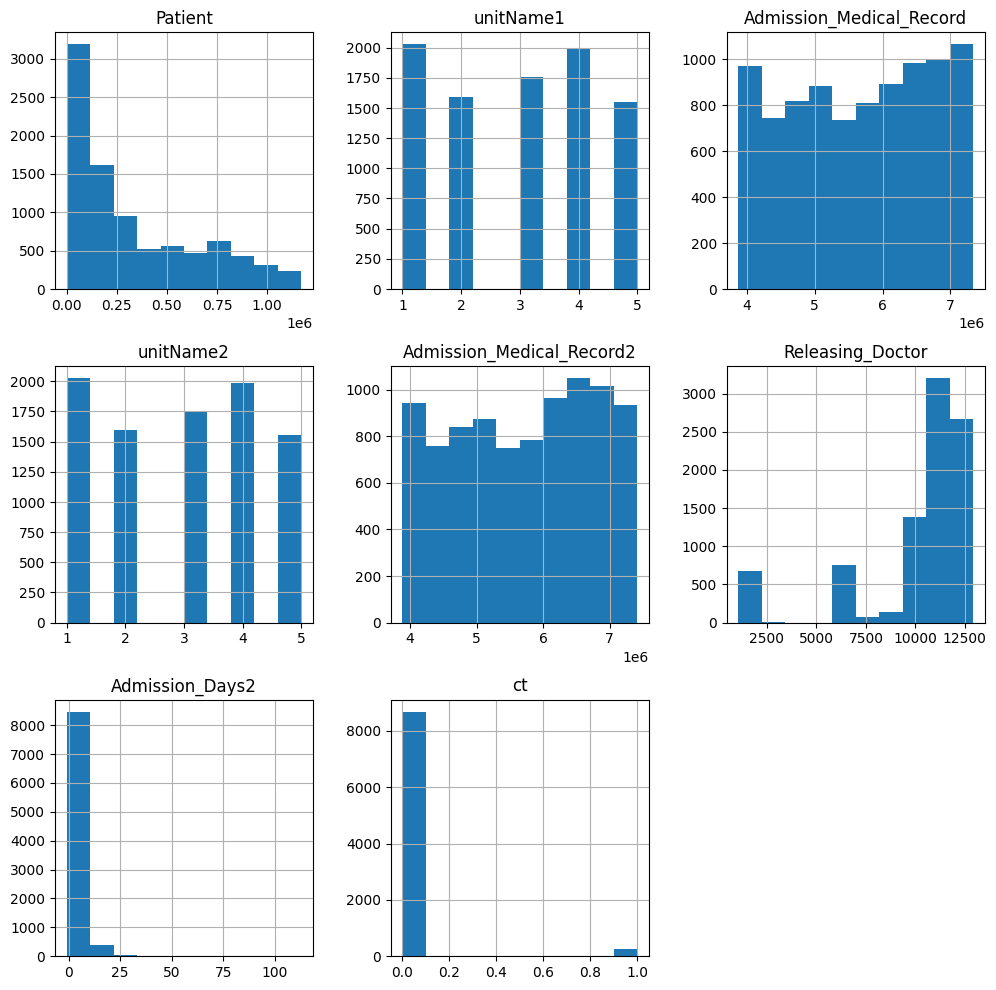

In [62]:
hospitalization2.histogram()

In [63]:
df_2.isna().sum()

Patient                      0
unitName1                    0
Admission_Medical_Record     0
Admission_Entry_Date         0
Release_Date                 0
unitName2                    0
Admission_Medical_Record2    0
Admission_Entry_Date2        0
Release_Date2                0
Entry_Type                   0
Patient_Origin               0
Release_Type                 0
Releasing_Doctor             0
Admission_Days2              0
Diagnosis_In_Reception       0
Diagnosis_In_Release         0
ct                           0
dtype: int64

In [64]:
# Add duration classification
processed_df_2 = process_rehospitalization_data(df=df_2, patient_col='Patient', admission_col='Admission_Entry_Date', release_col='Release_Date')
processed_df_2.head()

/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_1/task_24/patient_stas.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duration["duration_classification"] = df_duration[duration_col].apply(


,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,Entry_Type,...,Release_Type,Releasing_Doctor,Admission_Days2,Diagnosis_In_Reception,Diagnosis_In_Release,ct,hospitalization_count,previous_release,duration_between_hospitalizations,duration_classification
2106,31,4,4285143,2020-07-26 09:01:59.213,2020-07-27 18:01:00,4,4314756,2020-08-08 13:36:33.263,2020-08-10 16:00:00,urgent,...,home,10779,2,7865,7865,0,3,2020-07-27 18:01:00,-2.0,short
3613,31,4,4298122,2020-07-31 03:17:42.087,2020-07-31 15:45:00,4,4314756,2020-08-08 13:36:33.263,2020-08-10 16:00:00,urgent,...,home,10779,2,7865,7865,0,3,2020-07-27 18:01:00,3.0,medium
7802,184,2,6245307,2022-10-21 20:40:30.750,2022-10-23 15:50:00,2,6304881,2022-11-14 19:10:56.910,2022-11-15 14:40:00,urgent,...,home,11515,1,401,401,0,2,2022-10-11 12:39:00,10.0,medium
2476,305,1,3877629,2020-01-04 16:16:04.103,2020-01-06 14:57:00,1,3951517,2020-02-04 14:02:27.643,2020-02-05 14:06:00,urgent,...,home,6892,1,78609,78609,0,7,2020-01-06 14:57:00,-2.0,short
1150,305,1,3905672,2020-01-16 03:20:07.073,2020-01-23 13:59:00,1,3958841,2020-02-07 15:32:42.737,2020-02-11 15:14:00,urgent,...,home,10762,4,78609,78609,0,7,2020-01-06 14:57:00,9.0,medium


In [65]:
for date_col in ['Admission_Entry_Date', 'Release_Date','Admission_Entry_Date2', 'Release_Date2', 'previous_release']:
    processed_df_2[date_col] = normalize_date_column(processed_df_2, column_name=date_col)
    processed_df_2 = convert_date_to_numeric(processed_df_2, date_col)

/var/folders/b8/_2175njn05v2qj5673nczyfh0000gn/T/ipykernel_52366/4122365337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df_2[date_col] = normalize_date_column(processed_df_2, column_name=date_col)
/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_2/task_38/task_38.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = pd.to_datetime(df[column_name], errors='coerce')
/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_2/task_38/task_38.py

In [82]:
categorical_features2 = processed_df_2.select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_features2)

processed_df_2_encoded = encode_columns(processed_df_2, categorical_features2)

processed_df_2_encoded.head(20)

['Entry_Type', 'Patient_Origin', 'Release_Type', 'Diagnosis_In_Reception', 'Diagnosis_In_Release', 'duration_classification']


,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,Entry_Type,...,Release_Type,Releasing_Doctor,Admission_Days2,Diagnosis_In_Reception,Diagnosis_In_Release,ct,hospitalization_count,previous_release,duration_between_hospitalizations,duration_classification
2106,31,4,4285143,1595721600,1595808000,4,4314756,1596844800,1597017600,2,...,0,10779,2,961,1546,0,3,1595808000,-2.0,2
3613,31,4,4298122,1596153600,1596153600,4,4314756,1596844800,1597017600,2,...,0,10779,2,961,1546,0,3,1595808000,3.0,1
7802,184,2,6245307,1666310400,1666483200,2,6304881,1668384000,1668470400,2,...,0,11515,1,792,1384,0,2,1665446400,10.0,1
2476,305,1,3877629,1578096000,1578268800,1,3951517,1580774400,1580860800,2,...,0,6892,1,958,1543,0,7,1578268800,-2.0,2
1150,305,1,3905672,1579132800,1579737600,1,3958841,1581033600,1581379200,2,...,0,10762,4,958,1543,0,7,1578268800,9.0,1
8026,305,1,3905672,1579132800,1579737600,1,3951517,1580774400,1580860800,2,...,0,6892,1,958,1543,0,7,1579737600,-8.0,2
2741,305,1,3951517,1580774400,1580860800,1,3958841,1581033600,1581379200,2,...,0,10762,4,958,1543,0,7,1579737600,12.0,0
6738,305,1,3951517,1580774400,1580860800,1,3995901,1582416000,1583193600,2,...,1,7993,9,958,1194,0,7,1580860800,-2.0,2
3311,305,1,3958841,1581033600,1581379200,1,3995901,1582416000,1583193600,2,...,1,7993,9,958,1194,0,7,1580860800,2.0,1
2240,367,2,7302549,1702944000,1703462400,2,7336765,1704067200,1704931200,2,...,1,11233,10,740,1333,0,2,1699228800,43.0,0


In [67]:
processed_df_2_encoded.isna().sum()

Patient                              0
unitName1                            0
Admission_Medical_Record             0
Admission_Entry_Date                 0
Release_Date                         0
unitName2                            0
Admission_Medical_Record2            0
Admission_Entry_Date2                0
Release_Date2                        0
Entry_Type                           0
Patient_Origin                       0
Release_Type                         0
Releasing_Doctor                     0
Admission_Days2                      0
Diagnosis_In_Reception               0
Diagnosis_In_Release                 0
ct                                   0
hospitalization_count                0
previous_release                     0
duration_between_hospitalizations    0
duration_classification              0
dtype: int64

In [107]:
# Create a pipeline with features and target
pca_pipeline = PCAClassificationPipeline(
    df=processed_df_2_encoded,
    features=processed_df_2_encoded.columns,
    target='duration_classification',
    n_components=4,
    hidden_size=10,
    test_size=0.3,
    random_state=42
)

In [108]:
# Prepare data
X_train, X_test, y_train, y_test = pca_pipeline.prepare_data()

In [109]:
# Train the model
input_size = X_train.shape[1]
model = pca_pipeline.train_model(X_train, y_train, input_size, num_classes=3, num_epochs=100, learning_rate=0.01)

Epoch [10/100], Loss: 0.9702
Epoch [20/100], Loss: 0.8052
Epoch [30/100], Loss: 0.6513
Epoch [40/100], Loss: 0.5201
Epoch [50/100], Loss: 0.4220
Epoch [60/100], Loss: 0.3456
Epoch [70/100], Loss: 0.2874
Epoch [80/100], Loss: 0.2423
Epoch [90/100], Loss: 0.2046
Epoch [100/100], Loss: 0.1742


In [110]:
# Evaluate the model
pca_pipeline.evaluate_model(model, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       458
           1       0.97      0.86      0.91       352
           2       0.91      1.00      0.96       511

    accuracy                           0.96      1321
   macro avg       0.96      0.95      0.95      1321
weighted avg       0.96      0.96      0.95      1321



In [111]:
# Assuming y_test and y_pred are already computed
model.eval()
with torch.no_grad():
    outputs = model.forward(X_test)
    _, y_pred = torch.max(outputs.data, 1)

/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_1/hospital_models/generic_torch_model.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_true, palette="viridis")
/Users/soncity2/DataScience2/data-science2-lab-final-project/src/team_1/hospital_models/generic_torch_model.py:218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="viridis")


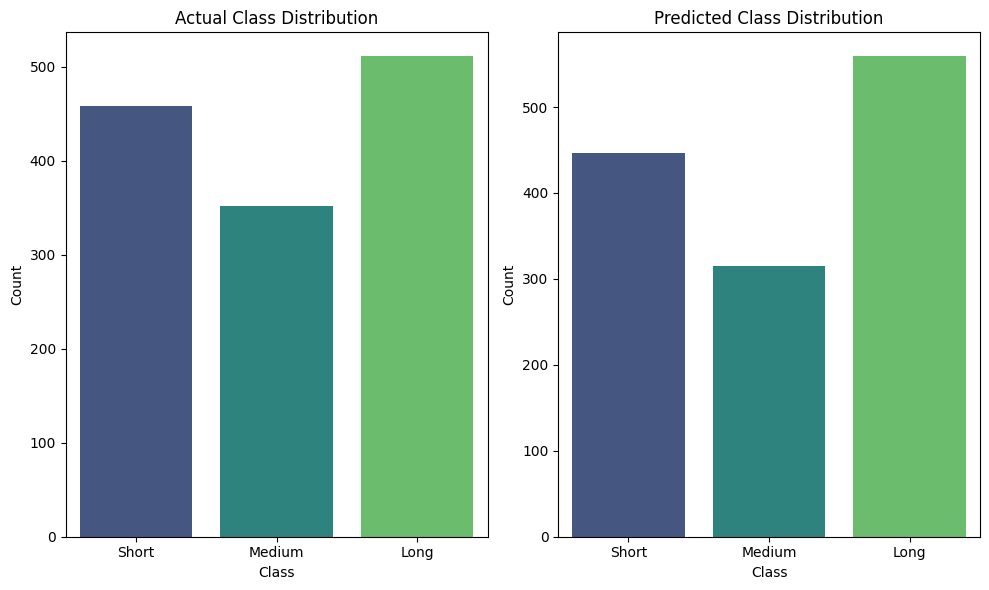

In [112]:
vis.plot_countplot(y_test, y_pred, class_names)

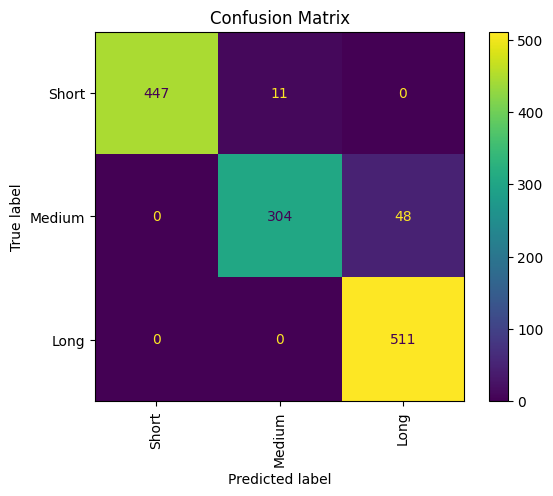

In [113]:
vis.plot_confusion_matrix(y_test, y_pred, class_names)